# Eagle8 benchmarking
This notebook is only to run the benchmark on `eagle8` for the $J$ average

In [1]:
using Revise
using HDF5
using CUDA
using Adapt
using Unitful
using Interpolations
using StaticArrays
import PhysicalConstants.CODATA2018: h, k_B, R_∞, c_0, m_e, m_u, e, ε_0, a_0
using BenchmarkTools
using PyPlot
using FastGaussQuadrature

using JLD2

using Vaf
using AtomicData

storage = "/mn/stornext/d10/data/chriskbl/"  # Storage location

device!(0) # for eagle8
CUDA.reclaim()

In [2]:
gpu_incline = "../scripts/gpu_incline.jl"
calc_line_gpu = "../scripts/calc_line_gpu.jl"
include(gpu_incline)
include(calc_line_gpu)

"""
Returns the nodes and weights form a Gaussian
quadrature with k points. Rescaled to an interval
from [0, 1].
"""
function gauss_quadrature(n)
    nodes, weights = gausslegendre(n)
    # Scaling from -1 to 1 to 0 to 1    
    return (nodes ./2 .+ 0.5, weights ./ 2)
end

function make_inclined(atmos::Atmosphere1D{3, T}) where T <: AbstractFloat
    tmp = Atmosphere1D(
                atmos.nx,
                atmos.ny,
                atmos.nz,
                atmos.z*μ,
                atmos.temperature,
                atmos.velocity_z,
                atmos.electron_density,
                atmos.hydrogen1_density,
                atmos.proton_density
                )
    atm = Adapt.adapt_structure(CuArray, tmp)
    return atm
end

function make_inclined(atmos::Atmosphere3D{T}) where T <: AbstractFloat
    tmp = Atmosphere3D(
                atmos.nx,
                atmos.ny,
                atmos.nz,
                atmos.x,
                atmos.y,
                atmos.z*μ,
                atmos.temperature,
                atmos.velocity_x,
                atmos.velocity_y,
                atmos.velocity_z,
                atmos.electron_density,
                atmos.hydrogen1_density,
                atmos.proton_density
                )
    atm = Adapt.adapt_structure(CuArray, tmp)
    return atm
end

make_inclined (generic function with 2 methods)

In [3]:
atmos1D = load(storage*"bifrost_cb24bih_s385_atm.jld2")["atmos"]
atmos = load(storage*"atmos3D.jld2")["atmos3D"]
itp_cpu = load(storage*"Halpha_itp_cont.jld2")["itp_cpu"]

atmos_gpu = Adapt.adapt_structure(CuArray, atmos)
#atmos1D_gpu = Adapt.adapt_structure(CuArray, atmos1D)
itp_gpu = Adapt.adapt_structure(CuArray{Float64}, itp_cpu)

const global_ndep = atmos.nz
const γ_mult = ustrip((h * c_0 / (4 * π)) |> u"J * nm")
const c_0u = ustrip(c_0)
const invSqrtPi = Float32(1. / sqrt(π));

my_line = load(storage*"my_line.jld2")["my_line"]
nu = load(storage*"nu.jld2")["nu"]
nl = load(storage*"nl.jld2")["nl"]

my_line_gpu = Adapt.adapt_structure(CuArray, my_line)
nl_gpu = CuArray(nl)
nu_gpu = CuArray(nu)

#=
α_c_cpu = load(storage*"alpha_c_cpu.jld2")["α_c_cpu"]
α_line_cpu = load(storage*"alpha_line_cpu.jld2")["α_line_cpu"]
S_cont_cpu = load(storage*"S_cont_cpu.jld2")["S_cont_cpu"]
S_line_cpu = load(storage*"S_line_cpu.jld2")["S_line_cpu"]
damp_cpu = load(storage*"damp_cpu.jld2")["damp_cpu"]
ΔλD_cpu = load(storage*"Delta_lambda_cpu.jld2")["ΔλD_cpu"];
=#

467×504×504 CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}:
[:, :, 1] =
 0.103801    0.104179    0.104698    …  0.104543    0.104159    0.103791
 0.104901    0.10408     0.103351       0.107656    0.106859    0.105834
 0.112341    0.111596    0.110727       0.114514    0.113643    0.11301
 0.123567    0.121601    0.119521       0.127035    0.126375    0.125336
 0.132669    0.130378    0.127711       0.136669    0.136064    0.134649
 0.138089    0.136067    0.134028    …  0.143412    0.141871    0.140106
 0.144078    0.14209     0.140281       0.150005    0.14824     0.146168
 0.148844    0.147347    0.145949       0.153904    0.152175    0.150498
 0.153013    0.151792    0.150567       0.156969    0.155601    0.154264
 0.155348    0.154057    0.153053       0.158625    0.157628    0.156546
 0.158485    0.156945    0.155757    …  0.163745    0.161941    0.160258
 0.165844    0.163533    0.161417       0.172619    0.170303    0.168237
 0.17865     0.175249    0.172475       0.190119    0.186

In [5]:
println(t_atmos)
println(t_line)

0.262125627
0.096415487


## CPU Speed

In [4]:

function incline_data_cpu!(
        data_in::AbstractArray{<: Real, 3},
        data_out::AbstractArray{<: Real, 3},
        z::AbstractVector,
        dx::Real,
        dy::Real,
        μ::Real,
        ϕ::Real,
)
    # Invert θ so that inclination goes towards increasing x or y values
    μ = -μ
    θ = acos(μ)
    sinθ = sin(θ)
    tanθ = sinθ / μ
    cosϕ = cos(ϕ)
    sinϕ = sin(ϕ)
    ∂x∂z = tanθ * cosϕ
    ∂y∂z = tanθ * sinϕ
    nz, ny, nx = size(data_in)
    @assert nz == length(z)
    @assert dx != 0
    @assert dy != 0
    ε = 1.0e-6
    changed = false

    if abs(∂x∂z) > ε   # μ shift in the x dimension
        incline_x_cpu!(data_in, data_out, ∂x∂z, z, dx)
        changed = true
    end

    if abs(∂y∂z) > ε   # ϕ shift in the y dimension
        if changed
            copy!(data_in, data_out)
        end
        incline_y_cpu!(data_in, data_out, ∂y∂z, z, dy)
    end

    return nothing
end

"""
Kernel for inclining in x dimension.
"""
function incline_x_cpu!(data_in, data_out, ∂x∂z, z, dx)
    nz, ny, nx = size(data_in)

    for l in 1:nx, n in 1:nz
        shift_x = ∂x∂z * z[n] / (nx*dx)
        (k, ac, bc, ad, bd) = Muspel._spline_coeffs(shift_x, nx)
        m1, p0, p1, p2 = Muspel._spline_stencil(l, k, nx)
        for m in 1:ny
            data_out[n,m,l] = ac*data_in[n,m,p0] + bc*data_in[n,m,p1] -
                              ad*data_in[n,m,m1] + bd*data_in[n,m,p2]
        end
    end
    return nothing
end

function incline_y_cpu!(data_in, data_out, ∂y∂z, z, dy)
    nz, ny, nx = size(data_in)

    for m in 1:ny, n in 1:nz
        shift_y = ∂y∂z * z[n] / (ny*dy)
        (k, ac, bc, ad, bd) = Muspel._spline_coeffs(shift_y, ny)
        m1, p0, p1, p2 = Muspel._spline_stencil(m, k, ny)
        for l in 1:nx
            data_out[n,m,l] = ac*data_in[n,p0,l] + bc*data_in[n,p1,l] -
                              ad*data_in[n,m1,l] + bd*data_in[n,p2,l]
        end
    end
    return nothing
end

function project_vlos_cpu!(
    vx::A,
    vy::A,
    vz::A,
    v_los::A,
    μ::Real,
    φ::Real,
) where A <: AbstractArray{<:Real}
    cosθ = μ
    sinθ = sqrt(1 - μ^2)
    cosφ = cos(φ)
    sinφ = sin(φ)
    project_kernel_cpu!(vx, vy, vz, v_los, cosθ, sinθ, cosφ, sinφ)
    return nothing
end


function project_kernel_cpu!(vx, vy, vz, v_los, cosθ, sinθ, cosφ, sinφ)
    nz, ny, nx = size(vx)
    for i in 1:nx, j in 1:ny, k in 1:nz
        v_los[k, j, i] = vx[k, j, i]*sinθ*cosφ + vy[k, j, i]*sinθ*sinφ + vz[k, j, i]*cosθ
    end
    return nothing
end



project_kernel_cpu! (generic function with 1 method)

In [5]:
function average_J_cpu!(intensity_in, intensity_out, weights_μ, weights_ϕ)
    for ix in 1:size(intensity_in, 3), iy in 1:size(intensity_in, 2), iz in 1:size(intensity_in, 1)
        intensity_out[iz, iy, ix] += intensity_in[iz, iy, ix] * weights_μ * weights_ϕ
    end
    return nothing
end

function calc_J_global_cpu!(J, nθ, line, atmos, n_up, n_lo, σ_itp, intensity)
    values_μ, weights_μ = gauss_quadrature(nθ)
    (nz, ny, nx) = size(intensity)

    nϕ = [0, π/2, π, 3π/2]
    dx = dy = atmos.x[2] - atmos.x[1]

    α_cont = zeros(Float32, (nz, ny, nx))
    α_line = zeros(Float32, (nz, ny, nx))
    S_cont = zeros(Float32, (nz, ny, nx))
    S_line = zeros(Float32, (nz, ny, nx))
    damp = zeros(Float32, (nz, ny, nx))
    ΔλD = zeros(Float32, (nz, ny, nx))
    v_los = zeros(Float32, (nz, ny, nx))

    α_cont_inclined = zeros(Float32, (nz, ny, nx))
    α_line_inclined = zeros(Float32, (nz, ny, nx))
    S_cont_inclined = zeros(Float32, (nz, ny, nx))
    S_line_inclined = zeros(Float32, (nz, ny, nx))
    damp_inclined = zeros(Float32, (nz, ny, nx))
    ΔλD_inclined = zeros(Float32, (nz, ny, nx))

    precalc_values2_cpu_single!(
                    α_cont, 
                    α_line, 
                    S_cont, 
                    S_line, 
                    damp, 
                    ΔλD, 
                    line, 
                    atmos, 
                    n_up, 
                    n_lo, 
                    σ_itp)

    for (μ, weights_μ) in zip(values_μ, weights_μ)
        #intensity_inclined = CUDA.zeros(Float32, (new_z, ny, nx))
        for (i, iϕ) in enumerate(nϕ)
            α_c_10 = log10.(α_cont)
            α_line_10 = log10.(α_line)
            S_cont_10 = log10.(S_cont)
            S_line_10 = log10.(S_line)
            damp_10 = log10.(damp)
            ΔλD_10 = log10.(ΔλD)

            incline_data_cpu!(α_c_10, α_cont_inclined, atmos.z, dx, dy, μ, iϕ)
            incline_data_cpu!(α_line_10, α_line_inclined, atmos.z, dx, dy, μ, iϕ)
            incline_data_cpu!(S_cont_10, S_cont_inclined, atmos.z, dx, dy, μ, iϕ)
            incline_data_cpu!(S_line_10, S_line_inclined, atmos.z, dx, dy, μ, iϕ)
            incline_data_cpu!(damp_10, damp_inclined, atmos.z, dx, dy, μ, iϕ)
            incline_data_cpu!(ΔλD_10, ΔλD_inclined, atmos.z, dx, dy, μ, iϕ)

            α_cont_inclined = 10 .^ α_cont_inclined
            α_line_inclined = 10 .^ α_line_inclined
            S_cont_inclined = 10 .^ S_cont_inclined
            S_line_inclined = 10 .^ S_line_inclined
            damp_inclined = 10 .^ damp_inclined
            ΔλD_inclined = 10 .^ ΔλD_inclined

            project_vlos_cpu!( 
                atmos.velocity_x,
                atmos.velocity_y,
                atmos.velocity_z,
                v_los,
                μ,
                iϕ,
                )
            calc_line_inclined_cpu!(
                                    line, 
                                    atmos, 
                                    α_cont_inclined, 
                                    α_line_inclined, 
                                    S_cont_inclined, 
                                    S_line_inclined, 
                                    damp_inclined, 
                                    ΔλD_inclined, 
                                    v_los,
                                    μ,
                                    intensity)
            average_J_cpu!(intensity, J, weights_μ, 1/4)
        end
    end
    return nothing
end

calc_J_global_cpu! (generic function with 1 method)

In [21]:
intensity = zeros(Float32, (atmos.nz, atmos.ny, atmos.nx))
J = zeros(Float32, (atmos.nz, atmos.ny, atmos.nx))
calc_J_global_cpu!(J, 4, my_line, atmos, nu, nl, itp_cpu, intensity)
# 199m 26.9s

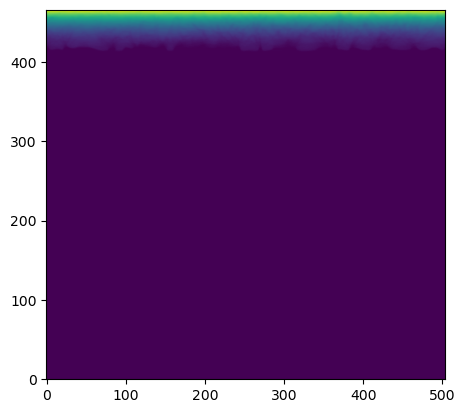

PyObject <matplotlib.image.AxesImage object at 0x7f2c172711e0>

In [22]:
imshow(J[:, :, 51])
#gcf()

In [6]:
nθ = 4
intensity = zeros(Float32, (atmos.nz, atmos.ny, atmos.nx))
J = zeros(Float32, (atmos.nz, atmos.ny, atmos.nx))
@benchmark calc_J_global_cpu!($J, $nθ, $my_line, $atmos, $nu, $nl, $itp_cpu, $intensity)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 23740.221 s (0.04% GC) to evaluate,
 with a memory estimate of 90.61 GiB, over 8480 allocations.

# Auto thread

In [6]:
function calc_J_global_cpu_thread!(J, nθ, line, atmos, n_up, n_lo, σ_itp, intensity)
    values_μ, weights_μ = gauss_quadrature(nθ)
    (nz, ny, nx) = size(intensity)

    nϕ = [0, π/2, π, 3π/2]
    dx = dy = atmos.x[2] - atmos.x[1]

    α_cont = zeros(Float32, (nz, ny, nx))
    α_line = zeros(Float32, (nz, ny, nx))
    S_cont = zeros(Float32, (nz, ny, nx))
    S_line = zeros(Float32, (nz, ny, nx))
    damp = zeros(Float32, (nz, ny, nx))
    ΔλD = zeros(Float32, (nz, ny, nx))
    v_los = zeros(Float32, (nz, ny, nx))

    α_cont_inclined = zeros(Float32, (nz, ny, nx))
    α_line_inclined = zeros(Float32, (nz, ny, nx))
    S_cont_inclined = zeros(Float32, (nz, ny, nx))
    S_line_inclined = zeros(Float32, (nz, ny, nx))
    damp_inclined = zeros(Float32, (nz, ny, nx))
    ΔλD_inclined = zeros(Float32, (nz, ny, nx))

    precalc_values2_cpu_single!(
                    α_cont, 
                    α_line, 
                    S_cont, 
                    S_line, 
                    damp, 
                    ΔλD, 
                    line, 
                    atmos, 
                    n_up, 
                    n_lo, 
                    σ_itp)

    for (μ, weights_μ) in zip(values_μ, weights_μ)
        #intensity_inclined = CUDA.zeros(Float32, (new_z, ny, nx))
        for (i, iϕ) in enumerate(nϕ)
            α_c_10 = log10.(α_cont)
            α_line_10 = log10.(α_line)
            S_cont_10 = log10.(S_cont)
            S_line_10 = log10.(S_line)
            damp_10 = log10.(damp)
            ΔλD_10 = log10.(ΔλD)

            incline_data_cpu!(α_c_10, α_cont_inclined, atmos.z, dx, dy, μ, iϕ)
            incline_data_cpu!(α_line_10, α_line_inclined, atmos.z, dx, dy, μ, iϕ)
            incline_data_cpu!(S_cont_10, S_cont_inclined, atmos.z, dx, dy, μ, iϕ)
            incline_data_cpu!(S_line_10, S_line_inclined, atmos.z, dx, dy, μ, iϕ)
            incline_data_cpu!(damp_10, damp_inclined, atmos.z, dx, dy, μ, iϕ)
            incline_data_cpu!(ΔλD_10, ΔλD_inclined, atmos.z, dx, dy, μ, iϕ)

            α_cont_inclined = 10 .^ α_cont_inclined
            α_line_inclined = 10 .^ α_line_inclined
            S_cont_inclined = 10 .^ S_cont_inclined
            S_line_inclined = 10 .^ S_line_inclined
            damp_inclined = 10 .^ damp_inclined
            ΔλD_inclined = 10 .^ ΔλD_inclined

            project_vlos_cpu!( 
                atmos.velocity_x,
                atmos.velocity_y,
                atmos.velocity_z,
                v_los,
                μ,
                iϕ,
                )
            calc_line_inclined_cpu_thread!(
                                    line, 
                                    atmos, 
                                    α_cont_inclined, 
                                    α_line_inclined, 
                                    S_cont_inclined, 
                                    S_line_inclined, 
                                    damp_inclined, 
                                    ΔλD_inclined, 
                                    v_los,
                                    μ,
                                    intensity)
            average_J_cpu!(intensity, J, weights_μ, 1/4)
        end
    end
    return nothing
end


calc_J_global_cpu_thread! (generic function with 1 method)

In [8]:
intensity = zeros(Float32, (atmos.nz, atmos.ny, atmos.nx))
J = zeros(Float32, (atmos.nz, atmos.ny, atmos.nx))
calc_J_global_cpu_thread!(J, 4, my_line, atmos, nu, nl, itp_cpu, intensity)


In [11]:
h5write("mean_cpu.h5", "J", J)

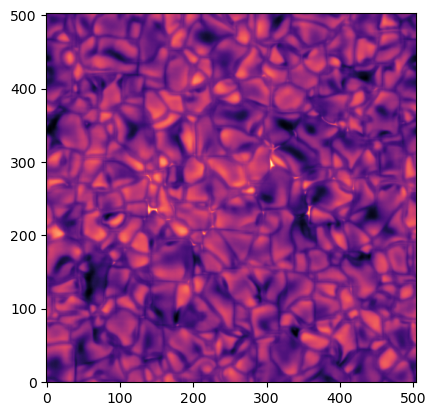

PyObject <matplotlib.image.AxesImage object at 0x7febd828b280>

In [9]:
imshow(J[51, :, :], cmap="magma")

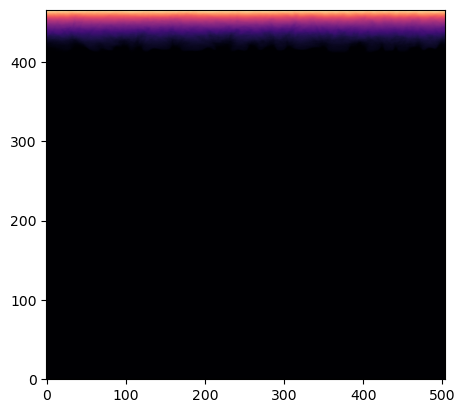

PyObject <matplotlib.image.AxesImage object at 0x7fe9f2f6d5d0>

In [10]:
imshow(J[:, 51, :], cmap="magma")

In [7]:
intensity = zeros(Float32, (atmos.nz, atmos.ny, atmos.nx))
J = zeros(Float32, (atmos.nz, atmos.ny, atmos.nx))
nθ = 4


4

In [9]:
@benchmark calc_J_global_cpu_thread!(
    $J, $nθ, $my_line, $atmos, $nu, $nl, $itp_cpu, $intensity)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 752.719 s (1.58% GC) to evaluate,
 with a memory estimate of 90.61 GiB, over 20457 allocations.

In [10]:
println("Number of threads: ", Threads.nthreads())

Number of threads: 128


In [ ]:
(nz, ny, nx) = size(intensity)

nϕ = [0, π/2, π, 3π/2]
dx = dy = atmos.x[2] - atmos.x[1]

α_cont = zeros(Float32, (nz, ny, nx))
α_line = zeros(Float32, (nz, ny, nx))
S_cont = zeros(Float32, (nz, ny, nx))
S_line = zeros(Float32, (nz, ny, nx))
damp = zeros(Float32, (nz, ny, nx))
ΔλD = zeros(Float32, (nz, ny, nx))
v_los = zeros(Float32, (nz, ny, nx))

α_cont_inclined = zeros(Float32, (nz, ny, nx))
α_line_inclined = zeros(Float32, (nz, ny, nx))
S_cont_inclined = zeros(Float32, (nz, ny, nx))
S_line_inclined = zeros(Float32, (nz, ny, nx))
damp_inclined = zeros(Float32, (nz, ny, nx))
ΔλD_inclined = zeros(Float32, (nz, ny, nx))


467×504×504 Array{Float32, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  

In [ ]:
μ = 0.9
iϕ = π/2

α_cont_inclined = rand(Float32, (atmos.nz, atmos.ny, atmos.nx))
α_line_inclined = rand(Float32, (atmos.nz, atmos.ny, atmos.nx))
S_cont_inclined = rand(Float32, (atmos.nz, atmos.ny, atmos.nx))
S_line_inclined = rand(Float32, (atmos.nz, atmos.ny, atmos.nx))
damp_inclined   = rand(Float32, (atmos.nz, atmos.ny, atmos.nx))
ΔλD_inclined    = rand(Float32, (atmos.nz, atmos.ny, atmos.nx))

v_los = rand(Float32, (atmos.nz, atmos.ny, atmos.nx))

467×504×504 Array{Float32, 3}:
[:, :, 1] =
 0.282445    0.95381    0.499807   …  0.591609   0.944218    0.82548
 0.599782    0.612394   0.867915      0.660469   0.73907     0.365441
 0.977144    0.587628   0.26688       0.137386   0.124565    0.842162
 0.398257    0.794186   0.125137      0.110108   0.85114     0.788627
 0.936123    0.990299   0.698137      0.834208   0.885205    0.610909
 0.169075    0.727739   0.943722   …  0.986595   0.550554    0.641748
 0.269637    0.0581492  0.944028      0.236984   0.221939    0.320678
 0.258309    0.163381   0.526283      0.0120643  0.993014    0.0321779
 0.898256    0.712304   0.663062      0.0919961  0.248142    0.608301
 0.00726324  0.323156   0.168755      0.26455    0.117362    0.789514
 0.459164    0.339998   0.0770889  …  0.976293   0.399003    0.810073
 0.419801    0.0428961  0.856352      0.453745   0.771446    0.417322
 0.905447    0.086557   0.773019      0.67408    0.407809    0.468574
 ⋮                                 ⋱           

In [ ]:
@benchmark calc_line_inclined_cpu_thread!(
                        $my_line, 
                        $atmos, 
                        $α_cont_inclined, 
                        $α_line_inclined, 
                        $S_cont_inclined, 
                        $S_line_inclined, 
                        $damp_inclined, 
                        $ΔλD_inclined, 
                        $v_los,
                        $μ,
                        $intensity)


BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 6.645 s (0.00% GC) to evaluate,
 with a memory estimate of 1.09 MiB, over 1280 allocations.

## GPU Speed

In [4]:
function average_J!(intensity_in, intensity_out, weights_μ, weights_ϕ)
    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    @inbounds if (ix <= size(intensity_in, 3) && iy <= size(intensity_in, 2))
        for iz in 1:size(intensity_in, 1)
            intensity_out[iz, iy, ix] += intensity_in[iz, iy, ix] * weights_μ * weights_ϕ
        end
    end
    return nothing
end

function calc_J_global!(J, nθ, line, atmos, n_up, n_lo, σ_itp, intensity, threads=(8, 8), blocks=(63, 63))
    values_μ, weights_μ = gauss_quadrature(nθ)
    (nz, ny, nx) = size(intensity)

    nϕ = [0, π/2, π, 3π/2]

    #threads = (8, 8)
    #blocks = (63, 63)
    CUDA.@allowscalar dx = dy = atmos.x[2] - atmos.x[1]

    α_cont = CUDA.zeros(Float32, (nz, ny, nx))
    α_line = CUDA.zeros(Float32, (nz, ny, nx))
    S_cont = CUDA.zeros(Float32, (nz, ny, nx))
    S_line = CUDA.zeros(Float32, (nz, ny, nx))
    damp = CUDA.zeros(Float32, (nz, ny, nx))
    ΔλD = CUDA.zeros(Float32, (nz, ny, nx))
    v_los = CUDA.zeros(Float32, (nz, ny, nx))

    α_cont_inclined = CUDA.zeros(Float32, (nz, ny, nx))
    α_line_inclined = CUDA.zeros(Float32, (nz, ny, nx))
    S_cont_inclined = CUDA.zeros(Float32, (nz, ny, nx))
    S_line_inclined = CUDA.zeros(Float32, (nz, ny, nx))
    damp_inclined = CUDA.zeros(Float32, (nz, ny, nx))
    ΔλD_inclined = CUDA.zeros(Float32, (nz, ny, nx))

    CUDA.@sync begin
        @cuda threads=threads blocks=blocks precalc_values2!(
                                    α_cont, 
                                    α_line, 
                                    S_cont, 
                                    S_line, 
                                    damp, 
                                    ΔλD, 
                                    line, 
                                    atmos, 
                                    n_up, 
                                    n_lo, 
                                    σ_itp)
    end

    for (μ, weights_μ) in zip(values_μ, weights_μ)
        #intensity_inclined = CUDA.zeros(Float32, (new_z, ny, nx))
        for (i, iϕ) in enumerate(nϕ)
            
            α_c_10 = log10.(α_cont)
            α_line_10 = log10.(α_line)
            S_cont_10 = log10.(S_cont)
            S_line_10 = log10.(S_line)
            damp_10 = log10.(damp)
            ΔλD_10 = log10.(ΔλD)

            incline_data_gpu!(α_c_10, α_cont_inclined, atmos.z, dx, dy, μ, iϕ, threads, blocks)
            incline_data_gpu!(α_line_10, α_line_inclined, atmos.z, dx, dy, μ, iϕ, threads, blocks)
            incline_data_gpu!(S_cont_10, S_cont_inclined, atmos.z, dx, dy, μ, iϕ, threads, blocks)
            incline_data_gpu!(S_line_10, S_line_inclined, atmos.z, dx, dy, μ, iϕ, threads, blocks)
            incline_data_gpu!(damp_10, damp_inclined, atmos.z, dx, dy, μ, iϕ, threads, blocks)
            incline_data_gpu!(ΔλD_10, ΔλD_inclined, atmos.z, dx, dy, μ, iϕ, threads, blocks)

            α_cont_inclined = 10 .^ α_cont_inclined
            α_line_inclined = 10 .^ α_line_inclined
            S_cont_inclined = 10 .^ S_cont_inclined
            S_line_inclined = 10 .^ S_line_inclined
            damp_inclined = 10 .^ damp_inclined
            ΔλD_inclined = 10 .^ ΔλD_inclined

            project_vlos_gpu!( 
                atmos.velocity_x,
                atmos.velocity_y,
                atmos.velocity_z,
                v_los,
                μ,
                iϕ,
                threads,
                blocks,
                )
            
            CUDA.@sync begin
                @cuda threads=(8, 8) blocks=(63, 63) calc_line_inclined_gpu!(
                                        line, 
                                        atmos, 
                                        α_cont_inclined, 
                                        α_line_inclined, 
                                        S_cont_inclined, 
                                        S_line_inclined, 
                                        damp_inclined, 
                                        ΔλD_inclined, 
                                        v_los,
                                        μ,
                                        intensity)
            end
            CUDA.@sync @cuda threads=(8, 8) blocks=(63, 63) average_J!(intensity, J, weights_μ, 1/4)
        end
    end
    return nothing
end

calc_J_global! (generic function with 3 methods)

In [10]:
intensity_gpu = CUDA.zeros(Float32, (atmos.nz, atmos.ny, atmos.nx))
J = CUDA.zeros(Float32, (atmos.nz, atmos.ny, atmos.nx))
nθ = 4
calc_J_global!(J, nθ, my_line_gpu, atmos_gpu, nu_gpu, nl_gpu, itp_gpu, intensity_gpu);
# Runtime 8m 12.3s

In [12]:
mean_intensity = Array(J)
h5write("mean_gpu.h5", "J", mean_intensity)

In [ ]:
println(size(intensity_gpu))
CUDA.@allowscalar imshow(J[1:end-1, :, 51], cmap="hot")
gcf()

In [ ]:
CUDA.@allowscalar imshow(J[end-1, :, :], cmap="hot")
gcf()


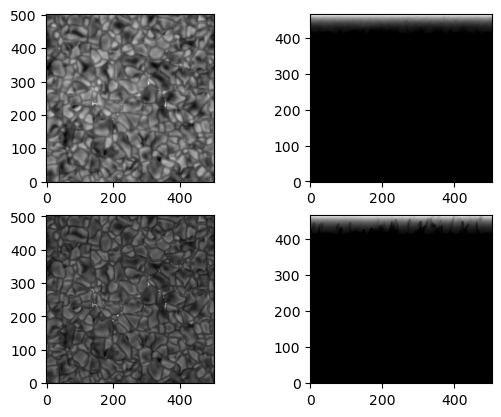

PyObject <matplotlib.image.AxesImage object at 0x7f31f2187910>

In [14]:
intensity_c = Array(intensity_gpu)
J_c = Array(J)
fig, axs = subplots(2, 2)
axs[1, 1].imshow(J_c[51, :, :], cmap="gray")
axs[1, 2].imshow(J_c[:, :, 51], cmap="gray")
axs[2, 1].imshow(intensity_c[51, :, :], cmap="gray")
axs[2, 2].imshow(intensity_c[:, :, 51], cmap="gray")
#savefig("inclined_J.pdf")

In [5]:
intensity_gpu = CUDA.zeros(Float32, (atmos.nz, atmos.ny, atmos.nx))
J = CUDA.zeros(Float32, (atmos.nz, atmos.ny, atmos.nx))
nθ = 4;

In [6]:
@benchmark calc_J_global!(
    $J, $nθ, $my_line_gpu, $atmos_gpu, $nu_gpu, $nl_gpu, $itp_gpu, $intensity_gpu)

LoadError: UndefVarError: `my_line_gpu` not defined

In [9]:
CUDA.memory_status()
function benchmark_GPU(J, nθ, my_line, atmos, nu, nl, itp, intensity_gpu, threads, blocks)
    my_line_gpu = Adapt.adapt_structure(CuArray, my_line)
    nu_gpu = CuArray(nu)
    nl_gpu = CuArray(nl)
    itp_gpu = Adapt.adapt_structure(CuArray{Float32}, itp)
    atmos_gpu = Adapt.adapt_structure(CuArray, atmos)

    calc_J_global!(J, nθ, my_line_gpu, atmos_gpu, nu_gpu, nl_gpu, itp_gpu, intensity_gpu, threads, blocks);
    return nothing
end


Effective GPU memory usage: 17.65% (5.602 GiB/31.733 GiB)
Memory pool usage: 3.977 GiB (4.000 GiB reserved)


benchmark_GPU (generic function with 1 method)

In [10]:
CUDA.reclaim()
J = CUDA.zeros(Float32, (atmos.nz, atmos.ny, atmos.nx))
intensity_gpu = CUDA.zeros(Float32, (atmos.nz, atmos.ny, atmos.nx))
nθ = 4
@benchmark benchmark_GPU($J, $nθ, $my_line, $atmos, $nu, $nl, $itp_cpu, $intensity_gpu)
#CUDA.memory_status()

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 862.544 s (0.05% GC) to evaluate,
 with a memory estimate of 1.17 MiB, over 29541 allocations.

In [ ]:
CUDA.memory_status()

Effective GPU memory usage: 99.94% (31.715 GiB/31.733 GiB)
Memory pool usage: 7.955 GiB (29.625 GiB reserved)


In [5]:
#CUDA.reclaim()
intensity_gpu = CUDA.zeros(Float32, (atmos.nz, atmos.ny, atmos.nx))
v_los_gpu = CUDA.rand(Float32, (atmos.nz, atmos.ny, atmos.nx))
α_cont_inclined = CUDA.rand(Float32, (atmos.nz, atmos.ny, atmos.nx))
α_line_inclined = CUDA.rand(Float32, (atmos.nz, atmos.ny, atmos.nx))
S_cont_inclined = CUDA.rand(Float32, (atmos.nz, atmos.ny, atmos.nx))
S_line_inclined = CUDA.rand(Float32, (atmos.nz, atmos.ny, atmos.nx))
damp_inclined = CUDA.rand(Float32, (atmos.nz, atmos.ny, atmos.nx))
ΔλD_inclined = CUDA.rand(Float32, (atmos.nz, atmos.ny, atmos.nx));

In [ ]:
@benchmark CUDA.@sync begin
                @cuda threads=(8, 8) blocks=(63, 63) calc_line_inclined_gpu!(
                                        $my_line_gpu, 
                                        $atmos_gpu, 
                                        $α_cont_inclined, 
                                        $α_line_inclined, 
                                        $S_cont_inclined, 
                                        $S_line_inclined, 
                                        $damp_inclined, 
                                        $ΔλD_inclined, 
                                        $v_los_gpu,
                                        $0.9,
                                        $intensity_gpu)
            end


BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 31.500 s (0.00% GC) to evaluate,
 with a memory estimate of 23.72 KiB, over 703 allocations.

In [5]:
intensity_gpu = CUDA.zeros(Float32, (atmos.nz, atmos.ny, atmos.nx))
v_los_gpu = CUDA.rand(Float32, (atmos.nz, atmos.ny, atmos.nx))
α_cont_inclined = CUDA.rand(Float32, (atmos.nz, atmos.ny, atmos.nx))
α_line_inclined = CUDA.rand(Float32, (atmos.nz, atmos.ny, atmos.nx))
S_cont_inclined = CUDA.rand(Float32, (atmos.nz, atmos.ny, atmos.nx))
S_line_inclined = CUDA.rand(Float32, (atmos.nz, atmos.ny, atmos.nx))
damp_inclined = CUDA.rand(Float32, (atmos.nz, atmos.ny, atmos.nx))
ΔλD_inclined = CUDA.rand(Float32, (atmos.nz, atmos.ny, atmos.nx));
threads = (8, 8)
blocks = (63, 63)

@benchmark @cuda threads=threads blocks=blocks calc_line_inclined_gpu!(
                        $my_line_gpu, 
                        $atmos_gpu, 
                        $α_cont_inclined, 
                        $α_line_inclined, 
                        $S_cont_inclined, 
                        $S_line_inclined, 
                        $damp_inclined, 
                        $ΔλD_inclined, 
                        $v_los_gpu,
                        $0.9,
                        $intensity_gpu)

BenchmarkTools.Trial: 1 sample with 3 evaluations.
 Single result which took 137.018 s (0.00% GC) to evaluate,
 with a memory estimate of 6.95 KiB, over 47 allocations.

In [11]:
function bench_calc_J_global!(J, nθ, line, atmos, n_up, n_lo, σ_itp, intensity, threads=(8, 8), blocks=(63, 63))
    values_μ, weights_μ = gauss_quadrature(nθ)
    (nz, ny, nx) = size(intensity)

    nϕ = [0, π/2, π, 3π/2]

    CUDA.@allowscalar dx = dy = (atmos.x[2] - atmos.x[1])/2

    α_c = CUDA.zeros(Float32, (nz, ny, nx))
    α_line = CUDA.zeros(Float32, (nz, ny, nx))
    S_cont = CUDA.zeros(Float32, (nz, ny, nx))
    S_line = CUDA.zeros(Float32, (nz, ny, nx))
    damp = CUDA.zeros(Float32, (nz, ny, nx))
    ΔλD = CUDA.zeros(Float32, (nz, ny, nx))
    v_los = CUDA.zeros(Float32, (nz, ny, nx))

    α_c_inclined = CUDA.zeros(Float32, (nz, ny, nx))
    α_line_inclined = CUDA.zeros(Float32, (nz, ny, nx))
    S_cont_inclined = CUDA.zeros(Float32, (nz, ny, nx))
    S_line_inclined = CUDA.zeros(Float32, (nz, ny, nx))
    damp_inclined = CUDA.zeros(Float32, (nz, ny, nx))
    ΔλD_inclined = CUDA.zeros(Float32, (nz, ny, nx))
    #=
    for (μ, weights_μ) in zip(values_μ, weights_μ)
        #intensity_inclined = CUDA.zeros(Float32, (new_z, ny, nx))
        for (i, iϕ) in enumerate(nϕ)
            
            α_c_10 = log10.(α_c)
            α_line_10 = log10.(α_line)
            S_cont_10 = log10.(S_cont)
            S_line_10 = log10.(S_line)
            damp_10 = log10.(damp)
            ΔλD_10 = log10.(ΔλD)

            incline_data_gpu!(α_c_10, α_c_inclined, atmos.z, dx, dy, μ, iϕ, threads, blocks)
            incline_data_gpu!(α_line_10, α_line_inclined, atmos.z, dx, dy, μ, iϕ, threads, blocks)
            incline_data_gpu!(S_cont_10, S_cont_inclined, atmos.z, dx, dy, μ, iϕ, threads, blocks)
            incline_data_gpu!(S_line_10, S_line_inclined, atmos.z, dx, dy, μ, iϕ, threads, blocks)
            incline_data_gpu!(damp_10, damp_inclined, atmos.z, dx, dy, μ, iϕ, threads, blocks)
            incline_data_gpu!(ΔλD_10, ΔλD_inclined, atmos.z, dx, dy, μ, iϕ, threads, blocks)

            α_c_inclined = 10 .^ α_c_inclined
            α_line_inclined = 10 .^ α_line_inclined
            S_cont_inclined = 10 .^ S_cont_inclined
            S_line_inclined = 10 .^ S_line_inclined
            damp_inclined = 10 .^ damp_inclined
            ΔλD_inclined = 10 .^ ΔλD_inclined

            project_vlos_gpu!( 
                atmos.velocity_x,
                atmos.velocity_y,
                atmos.velocity_z,
                v_los,
                μ,
                iϕ,
                threads,
                blocks,
                )
        end
    end
    =#
    
    return nothing
end

bench_calc_J_global! (generic function with 3 methods)

In [7]:
(nz, ny, nx) = size(intensity_gpu)
α_c = CUDA.zeros(Float32, (nz, ny, nx))
α_line = CUDA.zeros(Float32, (nz, ny, nx))
S_cont = CUDA.zeros(Float32, (nz, ny, nx))
S_line = CUDA.zeros(Float32, (nz, ny, nx))
damp = CUDA.zeros(Float32, (nz, ny, nx))
ΔλD = CUDA.zeros(Float32, (nz, ny, nx))
v_los = CUDA.zeros(Float32, (nz, ny, nx))


467×504×504 CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  

In [8]:
threads = (8, 8)
blocks = (63, 63)
@benchmark CUDA.@sync begin
        @cuda threads=threads blocks=blocks precalc_values2!(
                                    $α_c, 
                                    $α_line, 
                                    $S_cont, 
                                    $S_line, 
                                    $damp, 
                                    $ΔλD, 
                                    $my_line_gpu, 
                                    $atmos_gpu, 
                                    $nu_gpu, 
                                    $nl_gpu, 
                                    $itp_gpu)

end

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  637.113 ms … 637.699 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     637.473 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   637.451 ms ± 207.475 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █             █         █    █               █     █  █     █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁█▁▁█▁▁▁▁▁█ ▁
  637 ms           Histogram: frequency by time          638 ms <

 Memory estimate: 9.75 KiB, allocs estimate: 60.

In [9]:
J = CUDA.zeros(Float32, (atmos.nz, atmos.ny, atmos.nx))
nθ = 4;

In [12]:
@benchmark bench_calc_J_global!(
    $J, $nθ, $my_line_gpu, $atmos_gpu, $nu_gpu, $nl_gpu, $itp_gpu, $intensity_gpu, $threads, $blocks)

BenchmarkTools.Trial: 824 samples with 1 evaluation.
 Range (min … max):  285.054 μs … 12.905 ms  ┊ GC (min … max): 0.00% … 18.28%
 Time  (median):       5.522 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):     6.059 ms ±  3.083 ms  ┊ GC (mean ± σ):  7.04% ±  6.54%

   ▂ ▂ ▂ ▂ ▂ ▂ ▁ ▁  ▁ ▂ ▂   █           ▁ ▁ ▂ ▁    ▁   ▁ ▁ ▁ ▁  
  ▄█▁█▁█▁█▁█▁█▄█▅█▅▆█▁█▁█▁▁▄█▅▁▁▁▁▁▁█▇▆▁█▅█▇█▁█▇█▇▆███▇█▇█▇█▆█ ▇
  285 μs        Histogram: log(frequency) by time      12.2 ms <

 Memory estimate: 4.83 KiB, allocs estimate: 100.

## Comparison

## Mean intensity
For the single thread cpu version
[x]
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 23740.221 s (0.00% GC) to evaluate.
    with a memory estimate of X MiB, over X allocations.
```
[x]
For the 16 thread cpu version
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 2051 s (0.00% GC) to evaluate.
    with a memory estimate of 90.61 GiB, over 19818 allocations.
```
[x]
For the 32 thread cpu version
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 1262.5 s (0.00% GC) to evaluate.
    with a memory estimate of 90.61 GiB, over 19818 allocations.
```
[x]
For the 64 thread cpu version
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 903 s (0.00% GC) to evaluate.
    with a memory estimate of 90.61 GiB, over 19818 allocations.
```
[x]
For the 128 thread cpu version
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 752 s (0.00% GC) to evaluate.
    with a memory estimate of 90.61 GiB, over 19818 allocations.
```
[x] (8, 8) (63, 63)
For the GPU version with move
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 862.5 s (0.00% GC) to evaluate.
    with a memory estimate of 915.91 KiB, over 20692 allocations.

Memory usage: 31.715 GiB
```

## Inclined intensity
For the single thread cpu version
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 412.282 s (0.00% GC) to evaluate.
    with a memory estimate of 1000.12 KiB, over 504 allocations.
```

For the Multi thread cpu version
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 6.645 s (0.00% GC) to evaluate.
    with a memory estimate of 1.09 MiB, over 1280 allocations.
```

For the GPU version
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 31.5 s (0.00% GC) to evaluate.
    with a memory estimate of 23.72 KiB, over 703 allocations.

```

In [ ]:
gpu_time = 3.376
cpu_time_single_thread = 746.513
cpu_time_32_thread = 23.835

Speedup one thread

In [ ]:
println("Lower: ", cpu_time_single_thread / gpu_time)
println("Higher: ", cpu_time_single_thread / gpu_time)

Speedup 32 thread

In [ ]:
println("Lower: ", cpu_time_32_thread / gpu_time)
println("Higher: ", cpu_time_32_thread / gpu_time)

# The Watt usage. 
### CPU: 
* [AMD EPYC2 7742](https://www.amd.com/en/products/cpu/amd-epyc-7742)
* Max. boost clock: 3.4GHz
* Default TDP: 225W


### GPU:
* [NVIDIA Tesla V100S](https://images.nvidia.com/content/tesla/pdf/Tesla-V100-PCIe-Product-Brief.pdf)
* Total board power: 250 W

Assume that both are running at maximum to get the upperbound limit

In [ ]:
GPU_watt = 250 
CPU_watt = 225

GPU_energy = GPU_watt * gpu_time
CPU_energy_single_thread = CPU_watt * cpu_time_single_thread
CPU_energy_32_thread = CPU_watt * cpu_time_32_thread;

In [ ]:
println("Single thread: ", CPU_energy_single_thread / GPU_energy)
println("32 thread: ", CPU_energy_32_thread / GPU_energy)